# Ultimate data science challenge

## Part 1 ‐ Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15-minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import json
import pickle
import seaborn as sns
# time-series imports
from datetime import datetime
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, cv, plot_importance

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [2]:
#load data 
df = pd.read_json('logins.json')
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
df.shape

(93142, 1)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [5]:
# add a column to represent the number of logins during each time
df['login_count'] = 1
# convert the date to a datetime object, and set it as the index
df = df.set_index(pd.to_datetime(df['login_time'], unit='s'))[['login_count']]
df.head()

,login_count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [6]:
#checking if dataset has null values
df.isnull()

,login_count
login_time,
1970-01-01 20:13:18,False
1970-01-01 20:16:10,False
1970-01-01 20:16:37,False
1970-01-01 20:16:36,False
1970-01-01 20:26:21,False
...,...
1970-04-13 18:50:19,False
1970-04-13 18:43:56,False
1970-04-13 18:54:02,False


In [7]:
#filling missing values with '0'
df = df.fillna(0)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93142 entries, 1970-01-01 20:13:18 to 1970-04-13 18:54:23
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   login_count  93142 non-null  int64
dtypes: int64(1)
memory usage: 1.4 MB


In [9]:
df['time'] = pd.to_datetime(df.index)

In [10]:
df['month'] = df.time.dt.month
df['day'] = df.time.dt.day
df['hour'] = df.time.dt.hour
df['week'] = df.time.dt.week
df['weekday'] = df.time.dt.weekday

C:\Users\santo\AppData\Local\Temp/ipykernel_39332/3471649755.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['week'] = df.time.dt.week


In [11]:
df.head()

,login_count,time,month,day,hour,week,weekday
login_time,,,,,,,
1970-01-01 20:13:18,1,1970-01-01 20:13:18,1,1,20,1,3
1970-01-01 20:16:10,1,1970-01-01 20:16:10,1,1,20,1,3
1970-01-01 20:16:37,1,1970-01-01 20:16:37,1,1,20,1,3
1970-01-01 20:16:36,1,1970-01-01 20:16:36,1,1,20,1,3
1970-01-01 20:26:21,1,1970-01-01 20:26:21,1,1,20,1,3


## login activities in different months

In [12]:
#grouping by mnth 
print (df.groupby('month')['login_count'].aggregate(np.sum))

month
1    21239
2    24673
3    33723
4    13507
Name: login_count, dtype: int64


(array([0, 1, 2, 3]),
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4')])

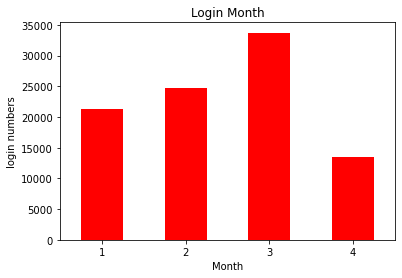

In [13]:
#visualize with a help of bargraph
df.groupby('month')['login_count'].sum().plot(kind='bar', color = 'red')
plt.title("Login Month")
plt.xlabel("Month")
plt.ylabel("login numbers")
plt.xticks(rotation=0)

March has the highest number pf logins where april has the least.

## weekely login activities

In [14]:
print (df.groupby('week')['login_count'].aggregate(np.sum))

week
1     2374
2     5217
3     5023
4     4751
5     4744
6     5572
7     5915
8     7035
9     6554
10    7398
11    7338
12    8955
13    7285
14    8095
15    6491
16     395
Name: login_count, dtype: int64


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12'),
  Text(12, 0, '13'),
  Text(13, 0, '14'),
  Text(14, 0, '15'),
  Text(15, 0, '16')])

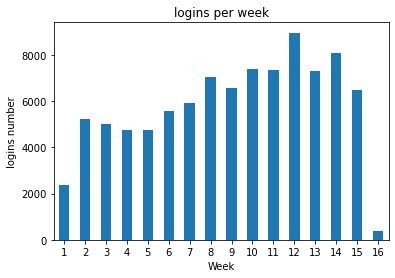

In [15]:
df.groupby('week')['login_count'].sum().plot(kind='bar')
plt.title("logins per week")
plt.xlabel("Week")
plt.ylabel("logins number")
plt.xticks(rotation=0)

week 12 has the most logins followed by week 14. On contray, week 16 has the least logins.

## Login activities in different weekdays

In [16]:
import calendar
nweek = 16 
print (df.groupby('weekday')['login_count'].aggregate(np.sum)/nweek)

weekday
0     551.4375
1     579.2500
2     646.1875
3     747.5000
4     950.5000
5    1211.0625
6    1135.4375
Name: login_count, dtype: float64


[Text(0, 0, 'Monday'),
 Text(1, 0, 'Tuesday'),
 Text(2, 0, 'Wednesday'),
 Text(3, 0, 'Thursday'),
 Text(4, 0, 'Friday'),
 Text(5, 0, 'Saturday'),
 Text(6, 0, 'Sunday')]

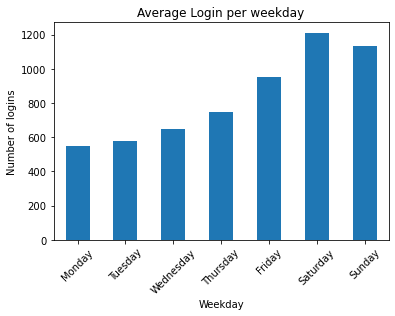

In [17]:
ax = (df.groupby('weekday')['login_count'].sum()/nweek).plot(kind='bar')
plt.title("Average Login per weekday")
plt.xlabel("Weekday")
plt.ylabel("Number of logins")
plt.xticks(rotation=45)
ax.set_xticklabels([calendar.day_name[d] for d in range(7)])

the logins keept increasing from monday to saturday gradually and then goes down by sunday. Having said that Saturday has the highest logins followed by sunday.

## logins activity

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23')])

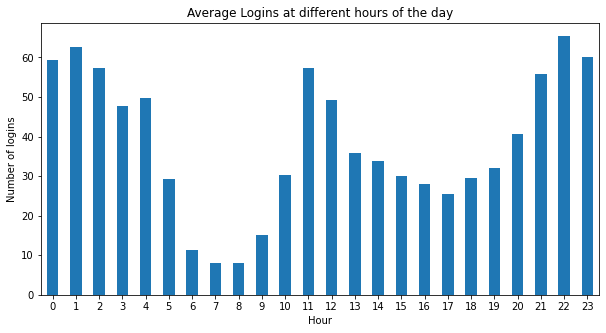

In [18]:
nday = 30+28+30+13   # total days
(df.groupby('hour')['login_count'].sum()/nday).plot(kind='bar', figsize=(10,5))
plt.title("Average Logins at different hours of the day")
plt.xlabel("Hour")
plt.ylabel("Number of logins")
plt.xticks(rotation=0)

logins rate are low in the morning time between 6 am to 9 am. 

SUMMARY OF FINDINGS
1. The month of march has the highest number of logins
2. Week 16 has the least logins and 12 has the most.
3. The logins keept increasing from monday to saturday gradually and then goes down by sunday.
4. Early mornig between 6 am to 9 am has the lowest logins traffic.

## Part 2 ‐ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
    a. how you will implement the experiment
            b. what statistical test(s) you will conduct to verify the significance of the observation
    c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.

Solution:
1. I will choose the toll costs driver parterns in two cities reimbursed and the percentage of the reimbursed costs by total toll costs incharged as the key measure of success of this experiment. If the toll costs of driver parterns reimbursed increase, it indicates that more driver parterns went to another city. If the percentage of the reimbursed costs by total toll costs incharged increase, it shows that more activities between two cities are taken by driver parterns. The bigger the costs reimbursed and percentage are, the more success this experiment is.

2. I will implement the experiment by collecting the data of the toll costs reimbursed, include date, time, cost, direction, driver parterns from which city, toll costs incharged. Then we will aggregate and anlalyze the data to find out the trend. If the costs reimbursed and percentage are increasing,

    I will conduct significance tests to verify the significance of the observation.

    I will visulize the experiment result of the trend, weekday, time of a day, direction, percentagae, ect. Then prepare a presentation to provide recommendations to the city operations team.

## Part 3 ‐ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate. The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

## Data description

● city: city this user signed up in
● phone: primary device for this user
● signup_date: date of account registration; in the form ‘YYYYMMDD’
● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
● avg_dist: the average distance in miles per trip taken in the first 30 days after signup
● avg_rating_by_driver: the rider’s average rating over all of their trips
● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
● surge_pct: the percent of trips taken with surge multiplier > 1
● avg_surge: The average surge multiplier over all of this user’s trips
● trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE
otherwise
● weekday_pct: the percent of the user’s trips occurring during a weekday

## DATA WRANGLING 

In [19]:
file = open('ultimate_data_challenge.json', 'r')
df1 = pd.DataFrame(json.load(file))
file.close()

df1.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [20]:
df1.columns

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver'],
      dtype='object')

In [21]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [22]:
# Fill in missing values
df1['avg_rating_by_driver'].fillna(df1['avg_rating_by_driver'].mean(), inplace=True)
df1['avg_rating_of_driver'].fillna(df1['avg_rating_of_driver'].mean(), inplace=True)
df1.dropna(axis=0, inplace=True)

In [23]:
df1 = df1.reset_index(drop=True)

In [24]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49604 entries, 0 to 49603
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49604 non-null  object 
 1   trips_in_first_30_days  49604 non-null  int64  
 2   signup_date             49604 non-null  object 
 3   avg_rating_of_driver    49604 non-null  float64
 4   avg_surge               49604 non-null  float64
 5   last_trip_date          49604 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               49604 non-null  float64
 8   ultimate_black_user     49604 non-null  bool   
 9   weekday_pct             49604 non-null  float64
 10  avg_dist                49604 non-null  float64
 11  avg_rating_by_driver    49604 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [25]:
# Convert dates to datetime format
df1['last_trip_date'] = pd.to_datetime(df1['last_trip_date'])
df1['signup_date'] = pd.to_datetime(df1['signup_date'])

In [26]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49604 entries, 0 to 49603
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49604 non-null  object        
 1   trips_in_first_30_days  49604 non-null  int64         
 2   signup_date             49604 non-null  datetime64[ns]
 3   avg_rating_of_driver    49604 non-null  float64       
 4   avg_surge               49604 non-null  float64       
 5   last_trip_date          49604 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               49604 non-null  float64       
 8   ultimate_black_user     49604 non-null  bool          
 9   weekday_pct             49604 non-null  float64       
 10  avg_dist                49604 non-null  float64       
 11  avg_rating_by_driver    49604 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

## EDA

In [27]:
# Create box plots of all categorical, non-date data
categorical_features = ['city', 'phone', 'ultimate_black_user']

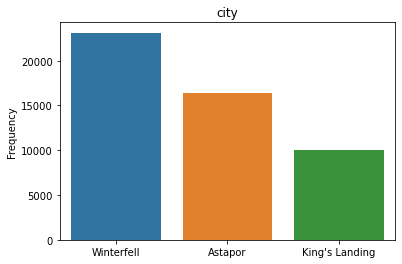

Winterfell        23125
Astapor           16413
King's Landing    10066
Name: city, dtype: int64


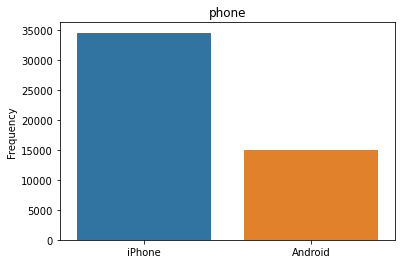

iPhone     34582
Android    15022
Name: phone, dtype: int64


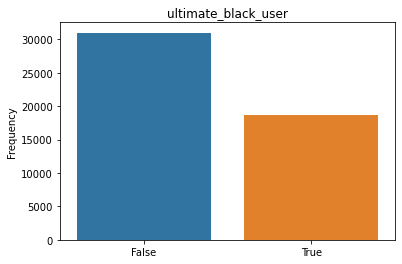

False    30992
True     18612
Name: ultimate_black_user, dtype: int64


In [28]:
for feature in categorical_features:
    sns.barplot(x = list(df1[feature].value_counts().index), y = df1[feature].value_counts())
    plt.title(feature)
    plt.ylabel('Frequency')
    plt.show()
    print(df1[feature].value_counts())

In [29]:
#distributions of numerical features
numerical_features = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 
                      'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'weekday_pct']

C:\Users\santo\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


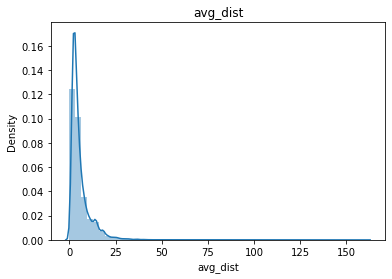

C:\Users\santo\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


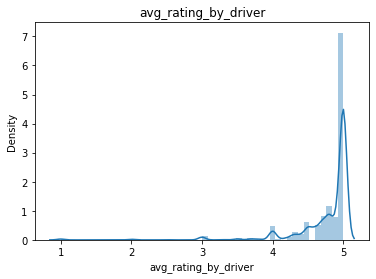

C:\Users\santo\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


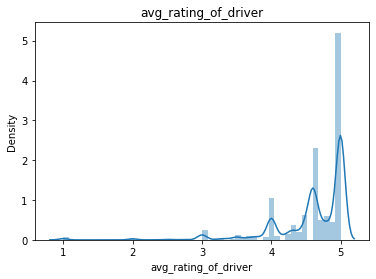

C:\Users\santo\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


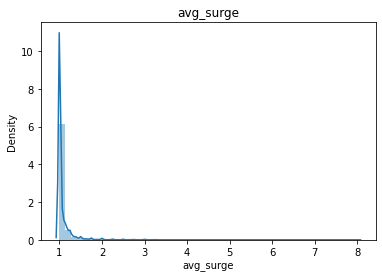

C:\Users\santo\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


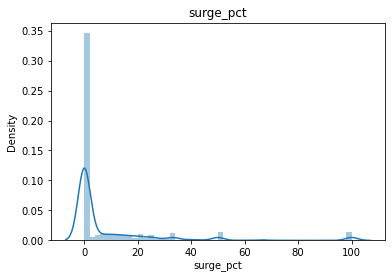

C:\Users\santo\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


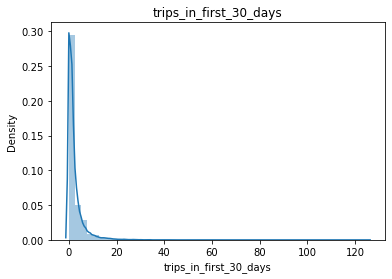

C:\Users\santo\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


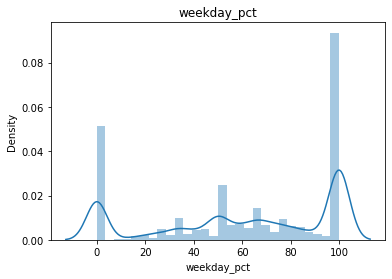

In [30]:
for feature in numerical_features:
    sns.distplot(df1[feature])
    plt.title(feature)
    plt.show();

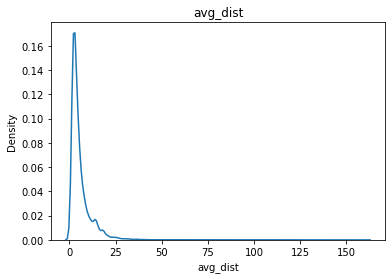

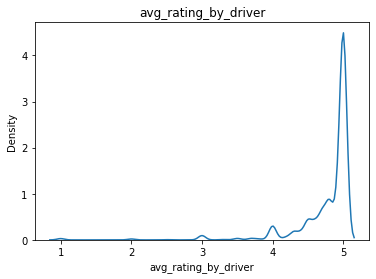

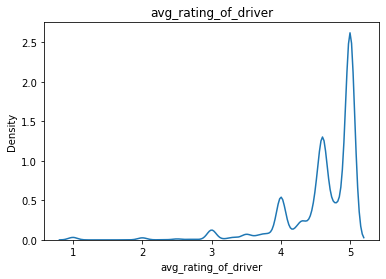

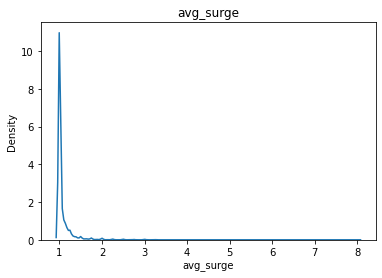

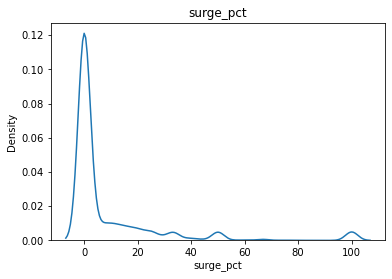

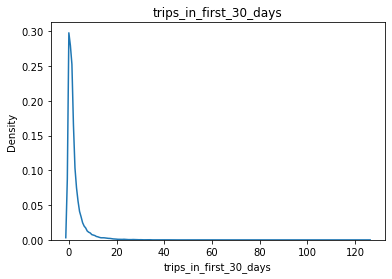

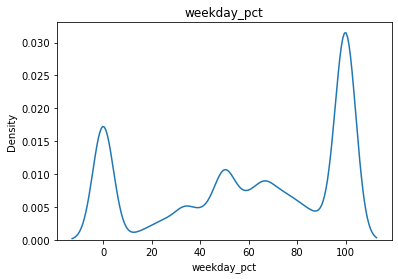

In [31]:
for feature in numerical_features:
    sns.kdeplot(df1[feature])
    plt.title(feature)
    plt.show();

In [32]:
df1.sort_values(by='last_trip_date').tail()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
45166,King's Landing,2,2014-01-25,4.4,1.14,2014-07-01,Android,17.9,False,83.9,2.32,4.8
12053,King's Landing,16,2014-01-18,4.9,1.02,2014-07-01,Android,3.9,False,74.0,2.64,4.8
18667,Astapor,3,2014-01-10,4.7,1.02,2014-07-01,iPhone,3.2,False,67.7,6.22,4.8
11999,Winterfell,1,2014-01-24,4.7,1.04,2014-07-01,iPhone,15.4,True,38.5,6.80,4.9
31351,Winterfell,12,2014-01-19,4.9,1.07,2014-07-01,iPhone,6.0,True,70.0,5.63,4.7


In [33]:
df1['last_trip_date'].sort_values().tail()

45166   2014-07-01
12053   2014-07-01
18667   2014-07-01
11999   2014-07-01
31351   2014-07-01
Name: last_trip_date, dtype: datetime64[ns]

from the data above we cn see that the latest 'last_trip_date' is 2014-07-01. As we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days, We consider a user retained if his 'last_trip_date' is after 2014-06-01.

## DATA MODELING 

In [34]:
df1['retained'] = (df1['last_trip_date'] > '2014-06-01')*1

In [35]:
df1.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [36]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49604 entries, 0 to 49603
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49604 non-null  object        
 1   trips_in_first_30_days  49604 non-null  int64         
 2   signup_date             49604 non-null  datetime64[ns]
 3   avg_rating_of_driver    49604 non-null  float64       
 4   avg_surge               49604 non-null  float64       
 5   last_trip_date          49604 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               49604 non-null  float64       
 8   ultimate_black_user     49604 non-null  bool          
 9   weekday_pct             49604 non-null  float64       
 10  avg_dist                49604 non-null  float64       
 11  avg_rating_by_driver    49604 non-null  float64       
 12  retained                49604 non-null  int32 

In [37]:
df1.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retained
count,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000
mean,2.277256,4.601482,1.074991,8.875314,60.883832,5.785418,4.777862,0.366503
std,3.793300,0.565227,0.222666,19.989018,37.086239,5.669709,0.446220,0.481854
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,4.500000,1.000000,0.000000,33.300000,2.420000,4.700000,0.000000
50%,1.000000,4.700000,1.000000,0.000000,66.700000,3.880000,5.000000,0.000000
75%,3.000000,5.000000,1.050000,8.700000,100.000000,6.930000,5.000000,1.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000,1.000000


### Frist Impressions

First impressions are that the users will need to be labled by active or inactive, and categorical variables must be encoded. The null values must be accounted for. While the reason for the missing ratings cannot be inferred, it seems reasonable that the user/driver simply declined to input a rating. In this case, we will fill with the mean value so as to not affect the current distribution, which is primarily high ratings.

In [38]:
#fill missing values in avg_rating_by_driver and avg_rating_of_driver
df1.avg_rating_by_driver = df1.avg_rating_by_driver.fillna(df1.avg_rating_by_driver.mean())
df1.avg_rating_of_driver = df1.avg_rating_of_driver.fillna(df1.avg_rating_of_driver.mean())

### Set Target Variable

The target variable will be whether the user was active in the sixth month from January (June). Convert the signup date and last trip date to datetime objects then encode each user active in June as True, else False

In [39]:
#set as datatime objects
df1.signup_date = pd.to_datetime(df1.signup_date)
df1.last_trip_date = pd.to_datetime(df1.last_trip_date)

In [40]:
#encode target variable 'active' as true or false for last trip in june
df1['active'] = [1 if x.month >= 6 else 0 for x in df1.last_trip_date]

#encode ultimate_black_user as categorical 
df1['ultimate_black_user'] = [1 if x == True else 0 for x in df1.ultimate_black_user]
df1 = df1.drop(['last_trip_date', 'signup_date'], axis =1)

## What is the ratio of Active Users to Inactive Users?

Percent of Active Users: 0.37640109668575117


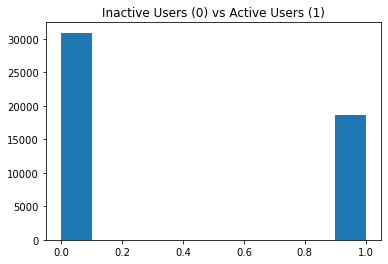

In [41]:
plt.hist(df1.active)
plt.title('Inactive Users (0) vs Active Users (1)')
plt.show
print('Percent of Active Users: {}'.format(sum(df1.active)/len(df1.active))) 

## Picking a Right Model

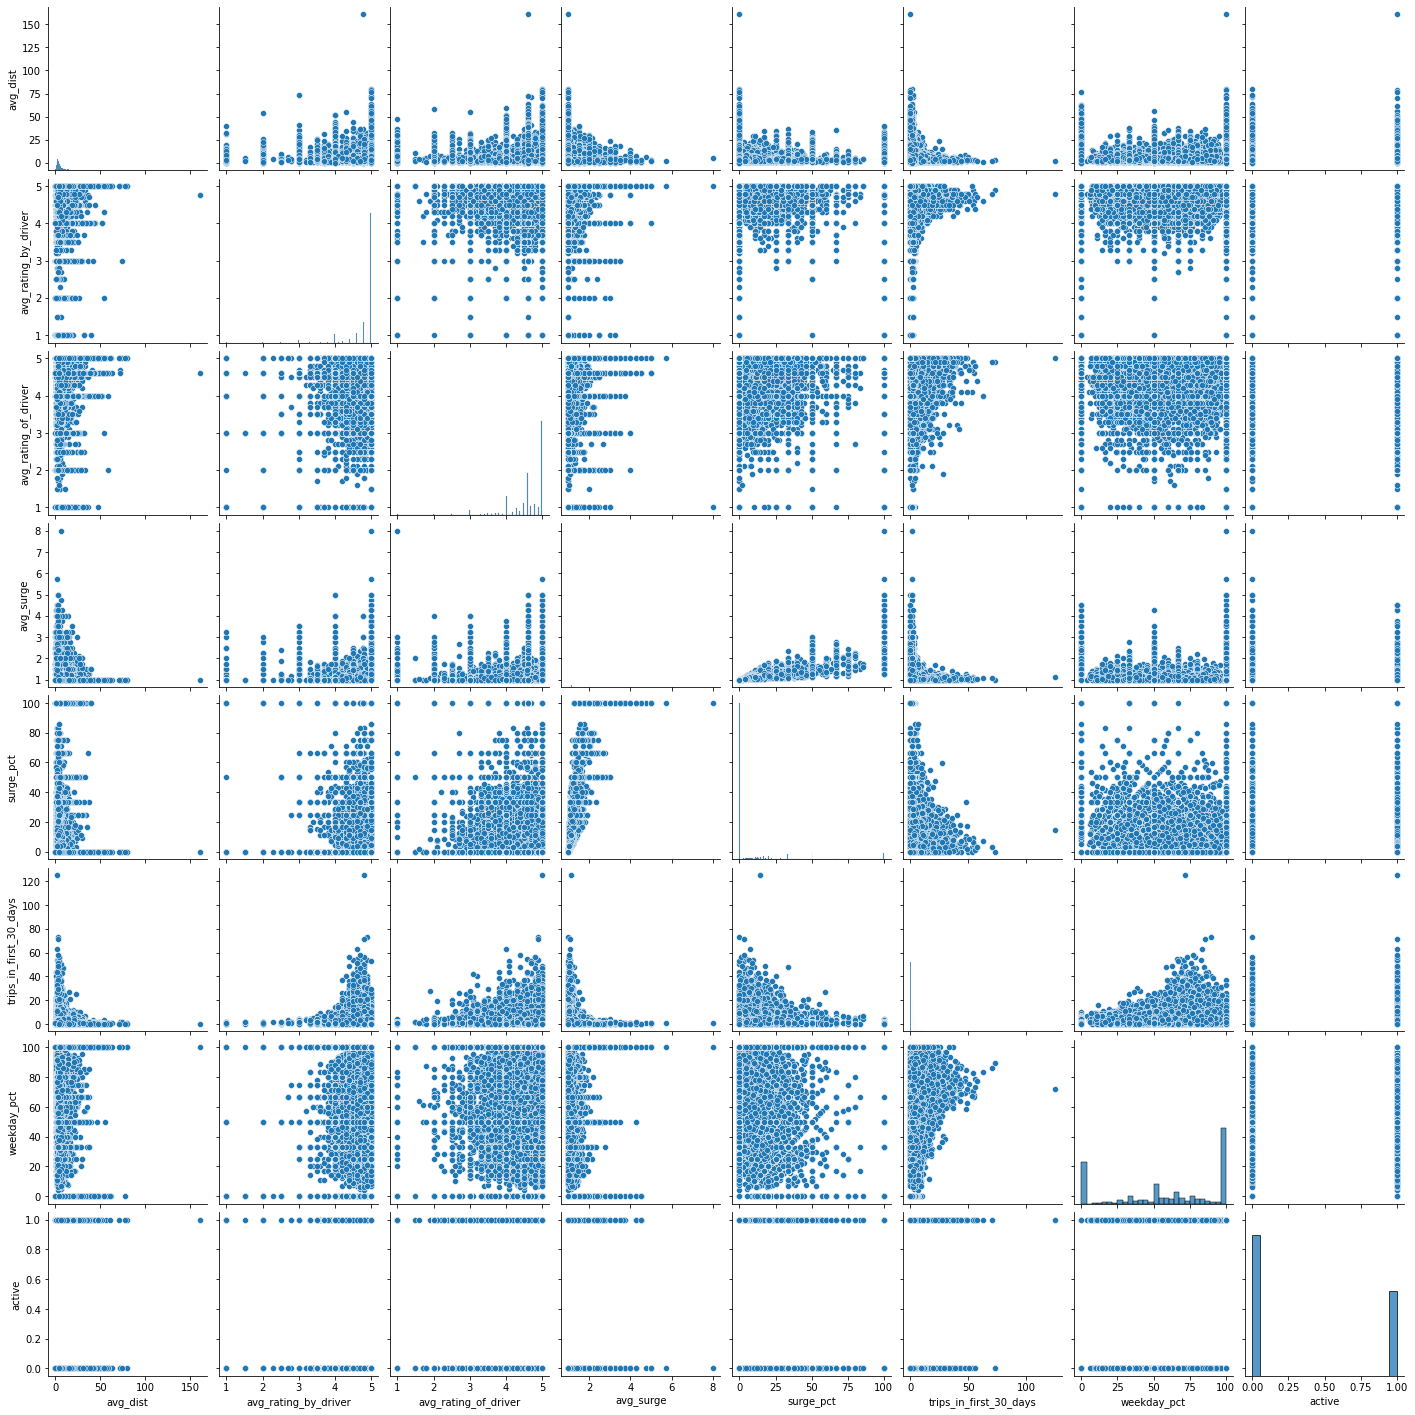

In [42]:
#select out only continuous variables
df1_pp = df1[['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
           'surge_pct', 'trips_in_first_30_days', 'weekday_pct', 'active']]
#plot
sns.pairplot(df1_pp)

from the correlations above we can see that some of the variables correlate with one another. This makes using a linear model an unlikely choice, since those assume that the variables are independent. This leaves us with the choice of a SVC, Kneighbors, and RandomForestClassifier. SVC fairs better with higher dimensional data, while RandomForestClassifier is susceptible to high levels of noise, so for this data the first choice will be Kneighbors.

In [43]:
df1 = pd.get_dummies(df1)
df1.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,active,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,1,1,0,1,0,0,1
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,0,0,1,0,0,1,0
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,0,0,1,0,0,0,1
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,1,1,0,1,0,0,1
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,0,0,0,0,1,1,0


## PREDICTIVE MODELING

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

In [45]:
#seperate data and labels
data = df1.drop('active', axis=1)
labels = df1.active

#split .33 to .67
X_train, y_train, X_test, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)

#normalize both sets post-split
X_train = normalize(X_train)
y_train = normalize(y_train)

In [46]:
from sklearn.neighbors import KNeighborsClassifier


In [47]:
#classifier with 10 neighbors
knn = KNeighborsClassifier(n_neighbors=10)

knn.fit(X_train, X_test)

#test the accuracy
knn.score(y_train, y_test)

0.9092852779474648

So, the KNN model give us an accuracy of about 91% Which is extraordinary.

In [48]:
from sklearn.model_selection import GridSearchCV

#specify a parameter grid to search over
parameters = {
    'n_neighbors': [10, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
}

knn_cv = GridSearchCV(knn, parameters, cv=5) #specify GridSearchCV object

knn_cv.fit(X_train, X_test) #fit to training data

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=10),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [10, 13, 15],
                         'weights': ['uniform', 'distance']})

In [49]:
#find classifiers best parameters
knn_cv.best_params_

{'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}

In [50]:
#check for accuracy improvement
knn_cv.score(y_train, y_test)

0.9368967623701894

After accuracy improvemet, the model is effective at the level of around 94%.

## Model Performance

In [51]:
from sklearn.metrics import classification_report, confusion_matrix

#predict classifications
y_pred = knn_cv.predict(y_train)

print(classification_report(y_test, y_pred)) # print classification report and confusion matrix

cm= confusion_matrix(y_test,y_pred)
print('confusion matrix:')
print(cm)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     10228
           1       0.93      0.90      0.91      6142

    accuracy                           0.94     16370
   macro avg       0.93      0.93      0.93     16370
weighted avg       0.94      0.94      0.94     16370

confusion matrix:
[[9786  442]
 [ 591 5551]]


In [52]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


In [53]:
import scikitplot as skplt
from sklearn.metrics import roc_auc_score

C:\Users\santo\anaconda\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


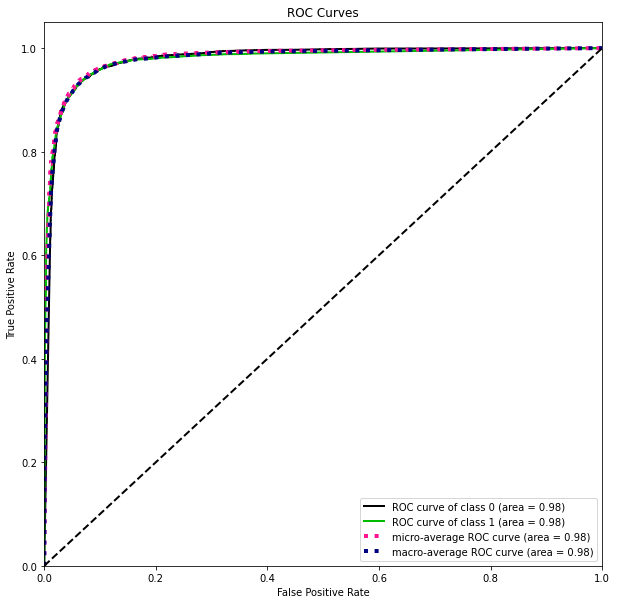

AUC score: 0.9302812832575214


In [54]:
#plot roc curve and  print AUV score
y_probas = knn_cv.predict_proba(y_train)
skplt.metrics.plot_roc_curve(y_test, y_probas, figsize=(10,10))
plt.show()
print('AUC score: {}'.format(roc_auc_score(y_test, y_pred)))

## Feature Selections

In [ ]:
from sklearn.model_selection import cross_val_score
n_feats = data.shape[1]

print('Feature  Accuracy')
for i in range(n_feats):
    X = data.iloc[:, i].values.reshape(-1, 1)
    knn_feat_test = KNeighborsClassifier(n_neighbors=13, weights='uniform', metric='manhattan')
    scores = cross_val_score(knn_feat_test, X, labels)
    print('%d        %g' % (i, scores.mean()))

Feature  Accuracy
0        0.647126
1        0.677627
2        0.704681
3        0.716454
4        0.627288
5        0.720506
6        0.591787
7        0.707887
8        0.990102
9        0.623599
10        0.664564
11        0.623599
12        0.607351
